In [1]:
# %matplotlib inline
%matplotlib notebook
import mpld3
from mpl_toolkits.mplot3d import Axes3D

mpld3.enable_notebook()
import matplotlib.pyplot as plt
import pandas as pd
import osmnx as ox
import networkx as nw
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns



import numpy as np
from scipy import integrate
from scipy.stats import iqr
import time
import seaborn as sns
from plotly.offline import iplot

import plotly.graph_objs as go
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from scipy import stats
from scipy.signal import find_peaks



# Load graph

In [20]:
filepath = './data/medellin.graphml'
G = ox.load_graphml(filepath)

# Covertir a GDF, Ccmbiar atributos y calcular shortest path (time)

<ipython-input-21-67bebb0d97f1>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>


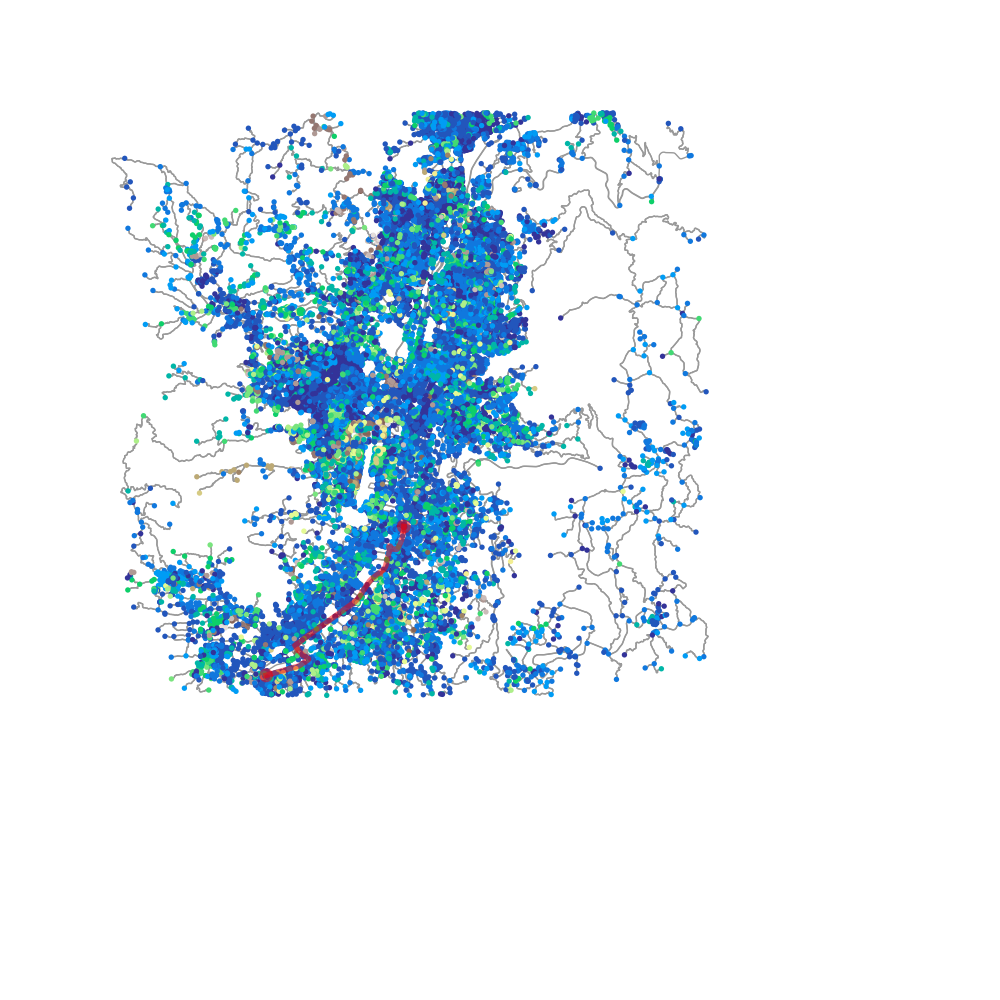

In [21]:
point_o = (6.202736, -75.577407)
point_d = (6.152245, -75.624450)
nearest_node_o = ox.distance.get_nearest_node(G, point_o, method='haversine', return_dist=True)
nearest_node_d = ox.distance.get_nearest_node(G, point_d, method='haversine', return_dist=True)
h_colors = ox.plot.get_node_colors_by_attr(G, 'elevation', cmap='terrain', num_bins=20)

nodes, edges = ox.graph_to_gdfs(G)

# Cambio a atributos de carretera
edges['highway'][edges['name']=='Carrera 10']='residential'

# Cambio a atributos de velocidad
fast=['motorway','trunk','motorway_link','trunk_link','escape','track']
mid = ['primary', 'primary_link', 'secondary','secondary_link']
slow = ['tertiary', 'residential','tertiary_link','living_street']
other = ['unclassified','road','service']

def find_speed(row):
    if row['highway'] in fast:
        return 80
    elif row['highway'] in mid:
        return 60
    elif row['highway'] in slow:
        return 30
    elif row['highway'] in other:
        return 40
    else:
        return 5


nodes, edges = ox.graph_to_gdfs(G)
edges = edges.assign(speed=edges.apply(find_speed, axis=1))

# Add time attribute
edges['time'] = edges['length']/edges['speed']

Graph2 = ox.graph_from_gdfs(nodes, edges)

shortest_path = nw.bellman_ford_path(G=Graph2, source=nearest_node_o[0],target=nearest_node_d[0], weight='time')
fig, ax = ox.plot.plot_graph_route(Graph2, route = list(shortest_path), bgcolor='w', node_color=h_colors )

<IPython.core.display.Javascript object>


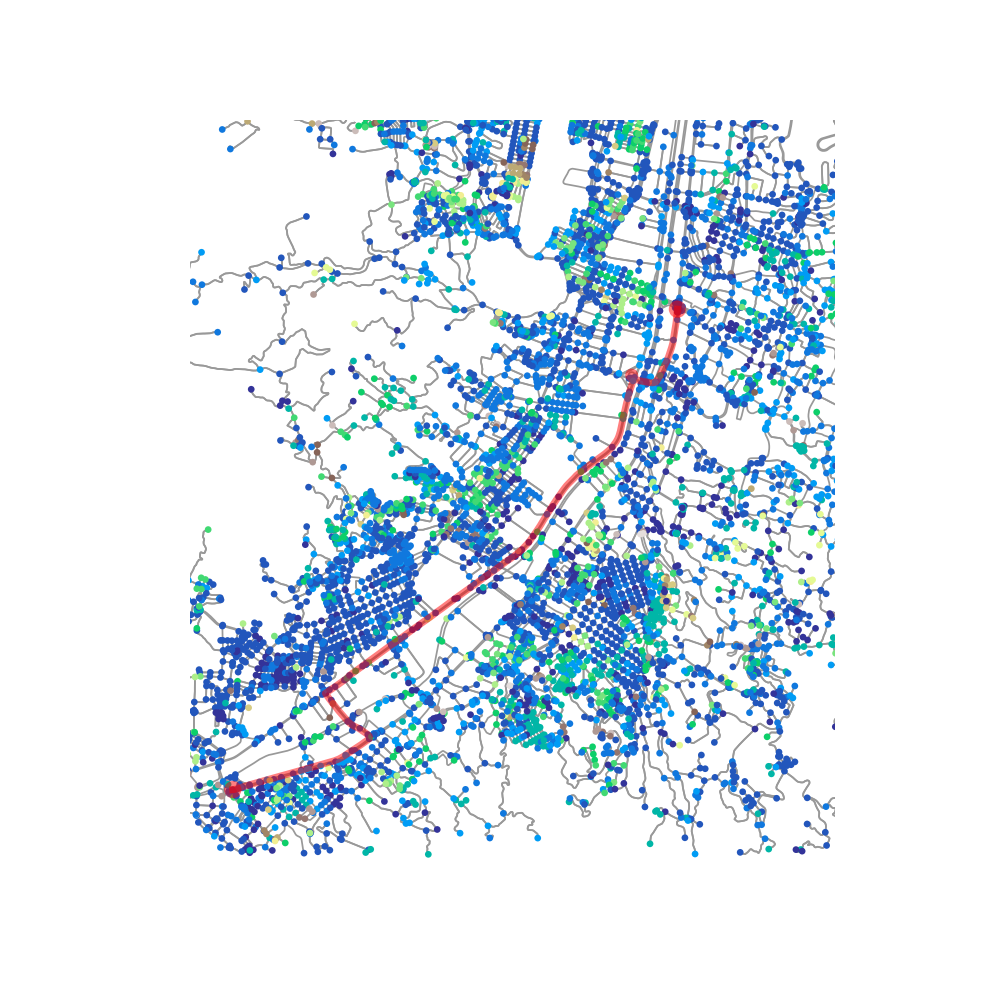

In [22]:
ax.figure


9185.216999999999
66


<IPython.core.display.Javascript object>


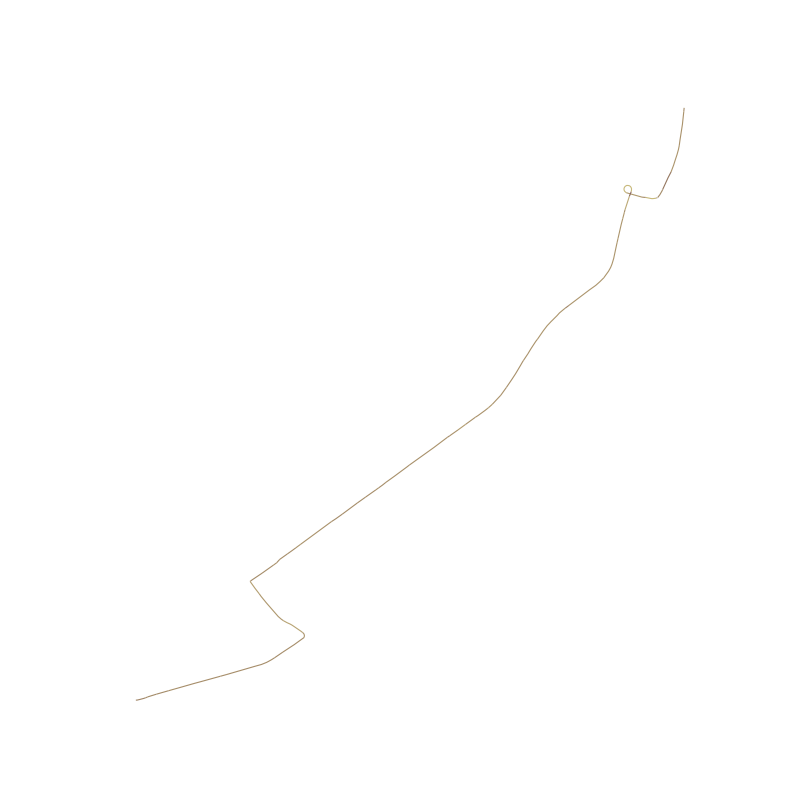

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [24]:
G_route = G.subgraph(shortest_path)
print(G_route.size(weight='length'))
print(len(G_route))
ec = ox.plot.get_edge_colors_by_attr(G_route, 'grade', cmap='terrain')
ox.plot_graph(G_route, edge_color=ec, edge_linewidth=0.8, node_size=0, bgcolor='w')

In [18]:
Graph2.size(weight='grade_abs')

3854.7809999999927

# Read operation data

In [5]:
df = pd.read_csv('C:\Users\Santiago\OneDrive - Universidad EAFIT\Documentos\Universidad\Maestria\Aplicacion/monitoreogrid/app/vehicle_operation.csv')
df.describe()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-5-d68b60e3d297>, line 1)

In [96]:
sub_df=df[['timestamp', 'power_kw', 'current', 'odometer', 'vehicle_id', 'run', 'capacity', 'slope', 'speed', 'mean_acc', 'latitude', 'longitude']].dropna(subset=['power_kw', 'odometer'])

sub_df=sub_df[(sub_df['vehicle_id'] == 'FSV110') | (sub_df['vehicle_id'] == "GHW284")]
sub_df=sub_df[(sub_df['odometer'] > 1)]
dates = pd.to_datetime(sub_df['timestamp'], format="%Y-%m-%d %H:%M:%S.%f")

x = np.array([time.mktime(t.timetuple()) for t in dates])
sub_df['timestamp']=x 

# Se eliminan errores en la medición de la aceleración
sub_df = sub_df[sub_df['mean_acc']>-5]
#sub_df[['timestamp','mean_acc']].plot.scatter(x='timestamp',y='mean_acc',figsize = [10,8])
sub_df.describe()

,timestamp,power_kw,current,odometer,run,capacity,slope,speed,mean_acc,latitude,longitude
count,1.128200e+04,11282.000000,11282.000000,11282.000000,11282.000000,11282.000000,11282.000000,11282.000000,11282.000000,11282.000000,11282.00000
mean,1.598703e+09,1.231678,7.022892,2089.250665,59.808008,28.541065,-0.042784,27.636057,-0.020341,6.202297,-75.55199
std,2.331361e+06,13.294855,33.649030,743.199857,123.421620,7.277783,3.842969,25.032417,0.411149,0.048577,0.04890
min,1.597084e+09,-48.081000,-127.500000,864.000000,0.000015,11.500000,-41.757700,0.000000,-3.330000,6.118190,-75.62470
25%,1.597165e+09,-2.438000,-3.500000,1030.000000,1.106152,24.100000,-1.203987,0.000000,-0.130000,6.164920,-75.57720
50%,1.597251e+09,0.000000,1.000000,2460.000000,39.526300,30.500000,0.000000,27.000000,0.000000,6.195735,-75.56030
75%,1.602279e+09,1.313750,23.500000,2637.000000,89.954275,33.300000,1.190173,48.000000,0.110000,6.230040,-75.54520
max,1.602334e+09,75.276000,225.000000,2804.000000,5724.680000,40.000000,43.531800,133.000000,3.420000,6.340530,-75.36670


Unidirected graph generation

In [116]:
UG = ox.get_undirected(G).edges(keys=True, data=True)

## Add osmnx atributes to operation data

In [127]:
#iloc me busca por el indice relativo al subdf 0 is 0
day2_autopista_suave=sub_df[(sub_df['vehicle_id'] == 'FSV110') & (sub_df['timestamp']>1597250800) & (sub_df['timestamp']<1597252000)]
X=day2_autopista_suave['longitude'].to_numpy()
Y=day2_autopista_suave['latitude'].to_numpy()
#points = [tuple(x) for x in day2_autopista_suave[['latitude', 'longitude']].to_numpy()]
nearest_edges = ox.distance.get_nearest_edges(G, X=X,Y=Y, method='balltree')

In [128]:
print(nearest_edges[0])

[344479270 344478760         0]


Función para añadir atributos de edge 

In [129]:
# edge_grades = [data['grade_abs'] for u, v, k, data in ox.get_undirected(G).edges(keys=True, data=True)]
def add_osmn_attributes_to_segment(UG, nearest_edges):
    list_attr = []
    for edge in nearest_edges:
        for u,v,k,data in UG:
            if [edge[0], edge[1]] == [v,u] or [edge[0], edge[1]] == [u,v]:
                list_attr.append(data)
                break
    return list_attr

list_of_attr = add_osmn_attributes_to_segment(UG, nearest_edges)

In [157]:
edge_df = pd.DataFrame(list_of_attr)
# real_route_with_attr = pd.concat([T1.reset_index(drop=True),T2.reset_index(drop=True)], axis=1)
real_route_with_attr = pd.concat([day2_autopista_suave.reset_index(drop=True),edge_df.reset_index(drop=True)], axis=1)
real_route_with_attr['measured_grade'] = np.tan(real_route_with_attr['slope']*np.pi/180)
real_route_with_attr[['timestamp', 'power_kw', 'current', 'odometer', 'capacity', 'slope', 'speed', 'mean_acc', 'grade',
                     'measured_grade', 'maxspeed', 'length', 'speed_kph', 'travel_time',  'lanes', 'ref', 'name',
                     'highway']].tail(60)
#print(real_route_with_attr.columns.to_list())

,timestamp,power_kw,current,odometer,capacity,slope,speed,mean_acc,grade,measured_grade,maxspeed,length,speed_kph,travel_time,lanes,ref,name,highway
78,1.597251e+09,60.620,177.25,2673.0,13.9,-3.519550,79.0,0.22,0.075,-0.061505,50,1021.750,50.0,73.6,2,56,Vía Las Palmas,primary
79,1.597251e+09,-13.202,-40.25,2674.0,13.8,5.142170,79.0,-0.49,-0.077,0.089990,50,1010.964,50.0,72.8,2,56,Vía Las Palmas,primary
80,1.597251e+09,72.290,221.75,2674.0,13.7,3.427620,83.0,0.55,0.075,0.059895,50,1021.750,50.0,73.6,2,56,Vía Las Palmas,primary
81,1.597251e+09,-0.839,-2.50,2674.0,13.7,5.200970,48.0,-0.30,-0.077,0.091024,50,1010.964,50.0,72.8,2,56,Vía Las Palmas,primary
82,1.597251e+09,44.587,134.50,2674.0,13.6,3.947350,52.0,0.57,-0.077,0.069003,50,1010.964,50.0,72.8,2,56,Vía Las Palmas,primary
83,1.597251e+09,-17.100,-50.00,2674.0,13.6,4.860210,47.0,-0.24,-0.077,0.085031,50,1010.964,50.0,72.8,2,56,Vía Las Palmas,primary
84,1.597251e+09,23.081,69.00,2674.0,13.6,4.420240,41.0,-0.37,0.075,0.077301,50,1021.750,50.0,73.6,2,56,Vía Las Palmas,primary
85,1.597251e+09,21.241,62.75,2674.0,13.6,3.830200,47.0,0.22,-0.077,0.066949,50,1010.964,50.0,72.8,2,56,Vía Las Palmas,primary
86,1.597251e+09,44.354,134.00,2674.0,13.5,5.462930,54.0,0.28,0.159,0.095636,NaN,28.382,36.6,2.8,2,NaN,NaN,primary_link
87,1.597251e+09,10.278,30.50,2674.0,13.4,4.772240,55.0,0.04,-0.073,0.083484,50,619.072,50.0,44.6,2,56,Vía Las Palmas,primary


<IPython.core.display.Javascript object>


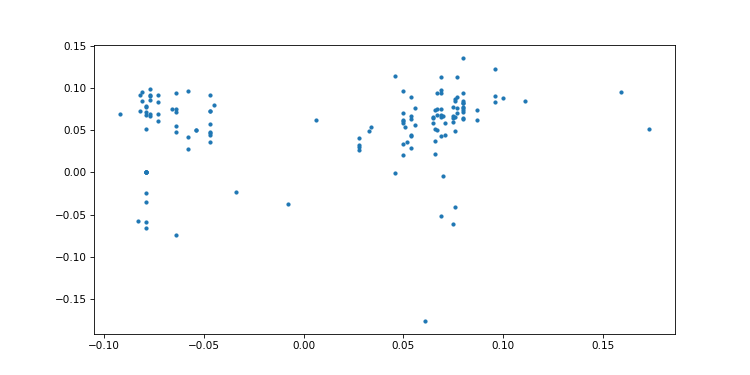

In [144]:
plt.figure(figsize=[10,5])
plt.plot(real_route_with_attr['grade'], real_route_with_attr['measured_grade'], ".")



# Generación de atributos por segmento


### Utilizaremos las siguientes funciones:

Los atributos a determinar son los siguientes:\
num_acc_minuto, \
num_acc_fr_minuto, \
prom_sobrepaso_acc, \
prom_sobrepaso_fren, \
prom_abs_acc, std_acc, \
num_jerk_acc_minuto, \
num_jerk_freno_minuto, \
prom_sobrepaso_jerk_acc, \
prom_sobrepaso_jerk_freno,\
prom_abs_jerk, std_jerk, \
std_potencia, \
prom_abs_potencia,  \
consumption, \
kms, \
consumption_per_km,\
num_current_minuto, \
num_current_fr_minuto, \
prom_sobrepaso_current, \
prom_sobrepaso_current_fr, \
prom_abs_current, \
std_current,\
std_current_std_jerk


In [347]:
def peak_features(trace, var, limit_u, limit_l, name):
    peaks, peak_values = find_peaks(var, height=limit_u) # mas de nedio acelerador
    valleys, valleys_values = find_peaks(-var, height=limit_l)
    num_peaks_minuto = 60 * len(peaks)/ (trace['timestamp2'].iloc[-1] - trace['timestamp2'].iloc[0])
    num_valleys_minuto = 60 * len(valleys)/ (trace['timestamp2'].iloc[-1] - trace['timestamp2'].iloc[0])

    prom_sobrepaso_peak = np.mean(peak_values['peak_heights'])/limit_u
    if np.isnan(prom_sobrepaso_peak):
      prom_sobrepaso_peak = 1

    # Promedio de sobrepaso de la referencia máxima de frenado
    prom_sobrepaso_valley = np.mean(valleys_values['peak_heights'])/limit_l
    if np.isnan(prom_sobrepaso_valley):
      prom_sobrepaso_valley = 1

    # Promedio de valor absoluto de la aceleración
    prom_abs = np.mean(np.absolute(var))
    std = np.std(var)
    max_val = np.max(var)
    return num_peaks_minuto, num_valleys_minuto, prom_sobrepaso_peak, prom_sobrepaso_valley, prom_abs, std, max_val


def feature_extraction(trace):
    trace['cumulative_distance'] = trace['run'].cumsum()

    # Picos aceleraciones y frenadas
    acc = trace['mean_acc'].to_numpy()
    num_acc_min, num_acc_fr_min, prom_sobrepaso_acc, prom_sobrepaso_fren, prom_abs_acc, std_acc, max_acc = peak_features(
        trace, acc, 1, 1, ',mean_acc')  # mas de nedio acelerador

    # Derivative of da/dt to find Jerk  - partir en otra función
    time_indexed_acc = pd.Series(acc, index=trace['timestamp2'])
    jerk = time_indexed_acc.diff().to_numpy()
    num_jerk_acc_min, num_jerk_freno_min, prom_sobrepaso_jerk_acc, prom_sobrepaso_jerk_freno, prom_abs_jerk, std_jerk, max_jerk = peak_features(
        trace, jerk[1:], 1.5, 1.5, 'jerk')  # mas de nedio acelerador

    # Picos corriente
    current = trace['current'].to_numpy()
    num_current_min, num_current_fr_min, prom_sobrepaso_current, prom_sobrepaso_current_fr, prom_abs_current, std_current, max_current = peak_features(
        trace, current, 115, 100, 'current')  # mas de nedio acelerador

    std_pot = np.std(trace['power_kw'])
    iqr_pot = iqr(trace['power_kw'])
    prom_abs_pot = np.mean(np.absolute(trace['power_kw'] ))
    consumption = trace['capacity'].iloc[0] - trace['capacity'].iloc[-1]
    kms = trace['cumulative_distance'].iloc[-1]/1000
    consumption_per_km = consumption / kms
    std_current_std_jerk = std_current * std_jerk
    max_speed = trace['speed'].max()
    mean_speed = trace['speed'].mean()
    median_speed = trace['speed'].median()
    std_speed = trace['speed'].std()
    time = trace['timestamp2'].iloc[-1] - trace['timestamp2'].iloc[0]

    # This indicator detects traffic (including red lights)
    stopped_time = 0
    old_time = trace['timestamp2'].iloc[0]
    prev = False
    for index, row in trace[['timestamp2', 'mean_speed']].iterrows():
        if row['mean_speed'] < 2:
            if prev:
                stopped_time += row['timestamp2'] - old_time
            
            old_time = row['timestamp2']     
            prev = True
        else:
            prev = False

    idle_time = stopped_time / time

    # ----------- Traffic features Pending [28] ----------
    # Number of stops
    # Idle time

    return [num_acc_min, num_acc_fr_min, prom_sobrepaso_acc, prom_sobrepaso_fren, prom_abs_acc, std_acc,
            num_jerk_acc_min, num_jerk_freno_min, prom_sobrepaso_jerk_acc,
            prom_sobrepaso_jerk_freno, prom_abs_jerk, std_jerk, std_pot, prom_abs_pot,  consumption,
            kms, consumption_per_km, num_current_min, num_current_fr_min, prom_sobrepaso_current,
            prom_sobrepaso_current_fr, prom_abs_current, std_current, std_current_std_jerk,
            trace['highway'].iloc[0], np.mean(trace['slope']), max_current, max_jerk, max_acc,
            trace['power_kw'].max(), max_speed, mean_speed, std_speed, iqr_pot, trace['soc'].mean(), time, idle_time,
            trace['user_id'].iloc[0], trace['vehicle_id'].iloc[0]]

In [205]:
complete_df = pd.read_csv('updated_vehicle_operation.csv', index_col='id')
complete_df

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning:

Columns (84) have mixed types.Specify dtype option on import or set low_memory=False.



,timestamp,placa,trace_id,operative_state,latitude,longitude,elevation,slope,speed,odometer,...,from,to,maxspeed,ref,junction,bridge,tunnel,access,width,trace_1
id,,,,,,,,,,,,,,,,,,,,,
5546,2020-08-10 13:21:40,NaN,-1.0,4,6.33970,-75.5485,1427.22,0.0,0.0,2361.0,...,2780700514,330253984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0
5547,2020-08-10 13:22:33,NaN,2.0,4,6.33970,-75.5485,1427.22,0.0,0.0,2361.0,...,2780700514,330253984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0
5548,2020-08-10 13:23:33,NaN,2.0,4,6.33970,-75.5485,1427.22,0.0,0.0,2361.0,...,2780700514,330253984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0
5549,2020-08-10 13:24:33,NaN,2.0,4,6.33970,-75.5485,1427.22,0.0,0.0,2361.0,...,2780700514,330253984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0
5550,2020-08-10 13:25:33,NaN,2.0,4,6.33970,-75.5485,1427.22,0.0,0.0,2361.0,...,2780700514,330253984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18781,2020-10-10 07:46:32,NaN,-869.0,1,6.19791,-75.5792,1503.83,0.0,0.0,1061.0,...,343200305,343200293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18782,2020-10-10 07:46:40,NaN,-869.0,1,6.19791,-75.5792,1503.83,0.0,0.0,1061.0,...,343200305,343200293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18783,2020-10-10 07:46:49,NaN,-869.0,1,6.19791,-75.5792,1503.83,0.0,0.0,1061.0,...,343200305,343200293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Segmentación de tramos para clasificación
Se define un nuevo tramo cada vez que el vehículo cambia de calle (cambia el nombre de la vía), y se cuentan los tramos que tengan más de x metros

In [343]:
trace_id = 1
aux_trace_id = -1
trace_array = np.array([])
suma = 0
old_name = ''

for index, row in complete_df.iterrows():
    suma = suma + row['run']
    #row['slope']
    trace_array = np.append(trace_array, aux_trace_id)
    nan = (row['name'] != row['name'])
    
    # Si recorre mas de 300 metros - cambiele el id del segmento actual de aux a definitivo para que se tenga en cuenta
    if suma >=1300:
        trace_array = np.where(trace_array == aux_trace_id, trace_id, trace_array)
        
    # Si cambia de vía - empiece un nuevo tramo se escoge 1000 para ver cambios en consumo
    if suma >=1300 or (old_name != row['name'] and not nan):  # pendiente
        suma = 0
        trace_id += 1
        aux_trace_id -= 1

    old_name = row['name']
    
trace_array

array([-1.000e+00, -2.000e+00, -2.000e+00, ..., -1.136e+03, -1.136e+03,
       -1.136e+03])

In [344]:
a=pd.Series(trace_array)
try:
    complete_df.drop(["trace_id"], axis=1, inplace
                     =True)
except KeyError:
    pass
complete_df.insert(2, "trace_id", trace_array, True)

In [345]:
complete_df.to_csv('updated_vehicle_operation.csv')

In [346]:
groups = complete_df.groupby(['highway'])
#groups.describe()
complete_df['trace_id'].describe()

count    11282.000000
mean       -26.905690
std        616.086338
min      -1136.000000
25%       -550.750000
50%         -2.000000
75%        444.000000
max       1133.000000
Name: trace_id, dtype: float64

# Generación del dataframe con los atributos de los segmentos identificados

In [293]:
classifier_df = complete_df[complete_df['trace_id'] > 0]

In [294]:
traces = classifier_df.groupby(['trace_id'])
#traces.describe()

In [350]:
cols = ['num_acc_min', 'num_acc_fr_min', 'prom_sobrepaso_acc', 'prom_sobrepaso_fren', 'prom_abs_acc',
            'std_acc', 'num_jerk_acc_min', 'num_jerk_freno_min', 'prom_sobrepaso_jerk_acc',
            'prom_sobrepaso_jerk_freno', 'prom_abs_jerk', 'std_jerk', 'std_pot', 'prom_abs_pot',
            'consumption', 'kms', 'consumption_per_km', 'num_current_min', 'num_current_fr_min',
            'prom_sobrepaso_current', 'prom_sobrepaso_current_fr', 'prom_abs_current', 'std_current',
            'std_current_std_jerk', 'highway', 'slope', 'max_current', 'max_jerk', 'max_acc', 'max_pot',
            'max_speed', 'mean_speed', 'std_speed', 'iqr_pot', 'mean_soc','travel_time', 'idle_time', 'user_id', 'vehicle_id']

lst=[]
for index, trace in traces:
    if index > 0 and len(trace) > 1:
        lst.append(feature_extraction(trace))
    
features = pd.DataFrame(lst, columns=cols)
features.dropna(subset=['num_acc_minuto'], inplace=True)
features.reset_index(inplace=True)
features = features[features['kms'] <= 1.6]
features['log_max_power'] = np.log(features['max_power'])
features['log_max_jerk'] = np.log(features['max_jerk'])
features['log_prom_abs_current'] = np.log(features['prom_abs_current'])
corr = features.corr()

features.tail(60)

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\pandas\core\series.py:726: RuntimeWarning:

divide by zero encountered in log

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\pandas\core\series.py:726: RuntimeWarning:

invalid value encountered in log



,index,num_acc_minuto,num_acc_fr_minuto,prom_sobrepaso_acc,prom_sobrepaso_fren,prom_abs_acc,std_acc,num_jerk_acc_minuto,num_jerk_freno_minuto,prom_sobrepaso_jerk_acc,...,max_current,max_jerk,max_acc,max_power,max_speed,mean_speed,std_speed,log_max_power,log_max_jerk,log_prom_abs_current
408,408,0.000000,0.491803,1.00,1.17,0.303684,0.445189,0.000000,0.491803,1.000000,...,27.00,0.79,0.71,14.981,50.0,25.157895,19.709736,2.706783,-0.235722,2.384553
409,409,0.000000,0.000000,1.00,1.00,0.560000,0.645041,0.000000,0.000000,1.000000,...,70.00,1.10,0.90,42.552,63.0,29.142857,21.466474,3.750727,0.095310,3.299059
410,410,0.000000,0.000000,1.00,1.00,0.280000,0.327887,0.000000,0.000000,1.000000,...,32.25,0.77,0.39,11.000,66.0,50.142857,12.562226,2.397895,-0.261365,2.814210
411,411,0.000000,0.000000,1.00,1.00,0.265000,0.265000,0.000000,0.000000,1.000000,...,-7.42,0.53,0.04,9.178,44.0,37.000000,9.899495,2.216809,-0.634878,2.707717
412,412,0.000000,0.000000,1.00,1.00,0.284000,0.240782,0.000000,0.000000,1.000000,...,27.93,0.47,0.57,10.060,44.0,28.200000,14.202113,2.308567,-0.755023,2.189864
413,413,0.000000,0.000000,1.00,1.00,0.440000,0.330000,0.000000,0.000000,1.000000,...,10.97,-0.66,-0.11,-5.429,47.0,36.000000,15.556349,NaN,NaN,3.284289
414,414,0.000000,0.000000,1.00,1.00,0.015714,0.041355,0.000000,0.000000,1.000000,...,8.36,0.08,0.15,0.089,26.0,3.142857,8.141604,-2.419119,-2.525729,-0.133531
415,415,0.000000,0.000000,1.00,1.00,0.352500,0.442994,0.000000,0.000000,1.000000,...,35.17,0.87,0.72,18.700,47.0,20.000000,16.725230,2.928524,-0.139262,2.460176
416,416,0.000000,0.000000,1.00,1.00,0.308333,0.389519,0.000000,0.000000,1.000000,...,28.30,0.69,0.48,14.364,36.0,31.833333,6.400521,2.664725,-0.371064,2.662123
417,417,0.000000,0.000000,1.00,1.00,0.318000,0.440254,0.000000,0.000000,1.000000,...,28.35,0.85,0.97,7.148,34.0,16.200000,8.978988,1.966833,-0.162519,2.095192


### Análisis de correlación entre atributos
Utilizando heatmap() de seaborn

<IPython.core.display.Javascript object>


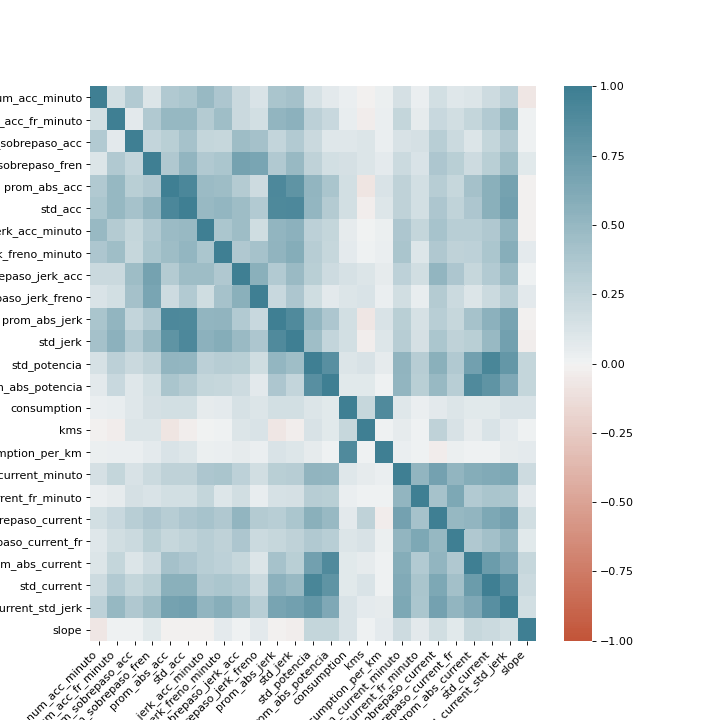

In [228]:
fig, ax = plt.subplots(figsize=[9,9])

ax = sns.heatmap(data = corr, vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=False)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### K-means para encontrar grupos de manejo

<IPython.core.display.Javascript object>


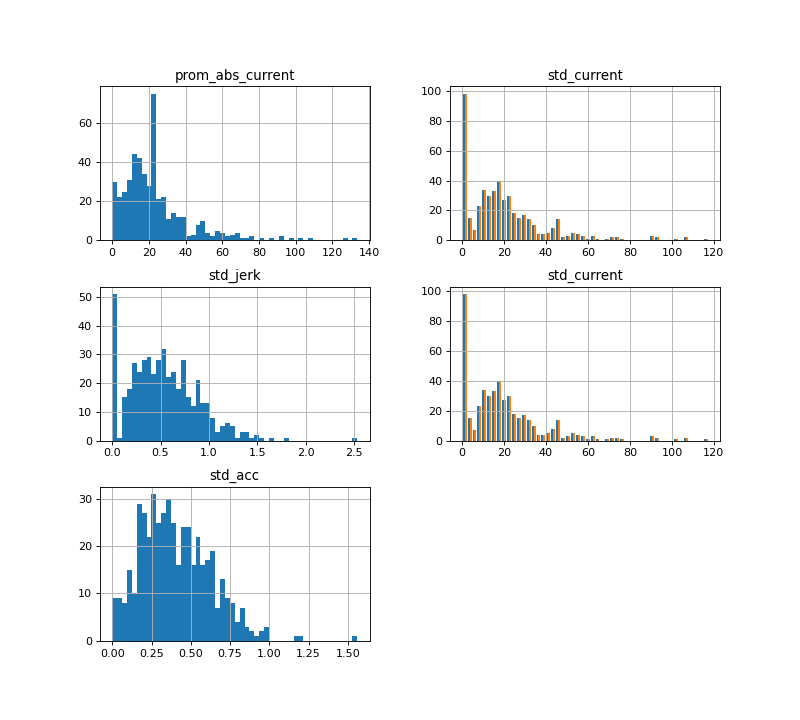

array([[<AxesSubplot:title={'center':'prom_abs_current'}>,
        <AxesSubplot:title={'center':'std_current'}>],
       [<AxesSubplot:title={'center':'std_jerk'}>,
        <AxesSubplot:title={'center':'std_current'}>],
       [<AxesSubplot:title={'center':'std_acc'}>, <AxesSubplot:>]],
      dtype=object)

In [348]:
features[['prom_abs_current', 'std_current', 'std_jerk', 'std_current', 'std_acc']].hist(figsize=[10,9],bins=50)

<IPython.core.display.Javascript object>


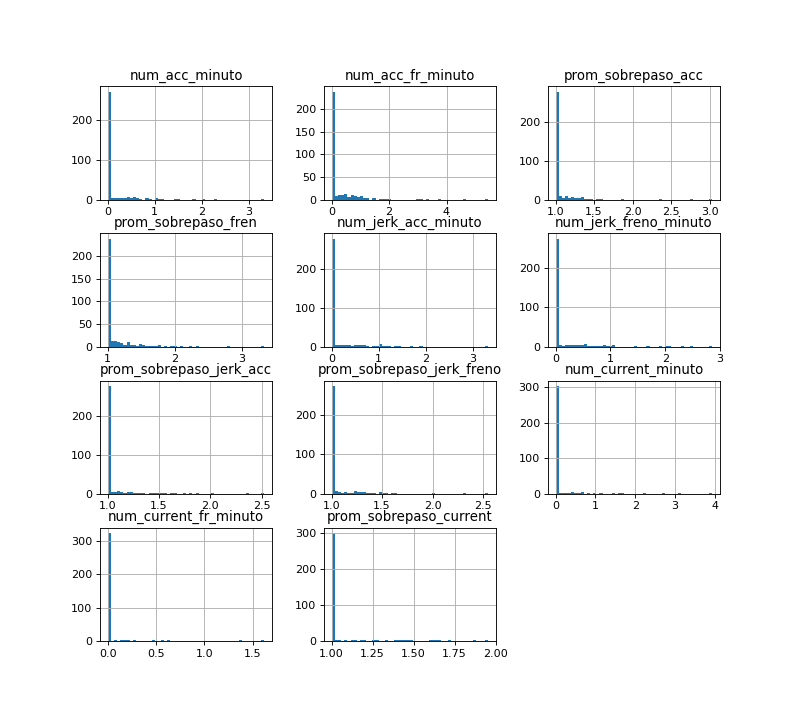

array([[<AxesSubplot:title={'center':'num_acc_minuto'}>,
        <AxesSubplot:title={'center':'num_acc_fr_minuto'}>,
        <AxesSubplot:title={'center':'prom_sobrepaso_acc'}>],
       [<AxesSubplot:title={'center':'prom_sobrepaso_fren'}>,
        <AxesSubplot:title={'center':'num_jerk_acc_minuto'}>,
        <AxesSubplot:title={'center':'num_jerk_freno_minuto'}>],
       [<AxesSubplot:title={'center':'prom_sobrepaso_jerk_acc'}>,
        <AxesSubplot:title={'center':'prom_sobrepaso_jerk_freno'}>,
        <AxesSubplot:title={'center':'num_current_minuto'}>],
       [<AxesSubplot:title={'center':'num_current_fr_minuto'}>,
        <AxesSubplot:title={'center':'prom_sobrepaso_current'}>,
        <AxesSubplot:>]], dtype=object)

In [234]:
features[['num_acc_minuto','num_acc_fr_minuto','prom_sobrepaso_acc','prom_sobrepaso_fren','num_jerk_acc_minuto', 
         'num_jerk_freno_minuto', 'prom_sobrepaso_jerk_acc', 'prom_sobrepaso_jerk_freno' , 'num_current_minuto',
         'num_current_fr_minuto', 'prom_sobrepaso_current']].hist(figsize=[10,9],bins=50)

<IPython.core.display.Javascript object>


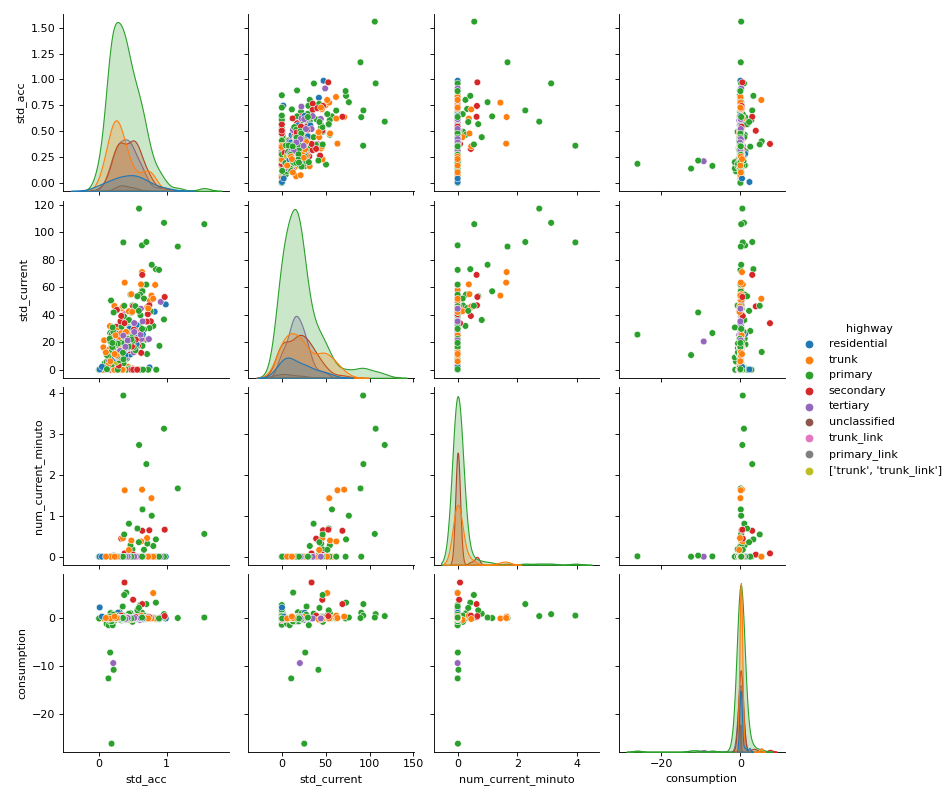

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

C:\Users\sechava4.PTOF56559.001\anaconda3_2\envs\monitoreo\lib\site-packages\seaborn\distributions.py:305: UserWarning:

Dataset has 0 

In [235]:
sns.pairplot(features.dropna(), hue='highway', vars=['max_current', 'std_potencia', 'slope', 'prom_abs_current',
                                                     'max_power', 'log_max_power', 'max_jerk', 'consumption',
                                                     'max_speed'], kind='scatter')

### Datos de entrada al modelo de clustering

<IPython.core.display.Javascript object>


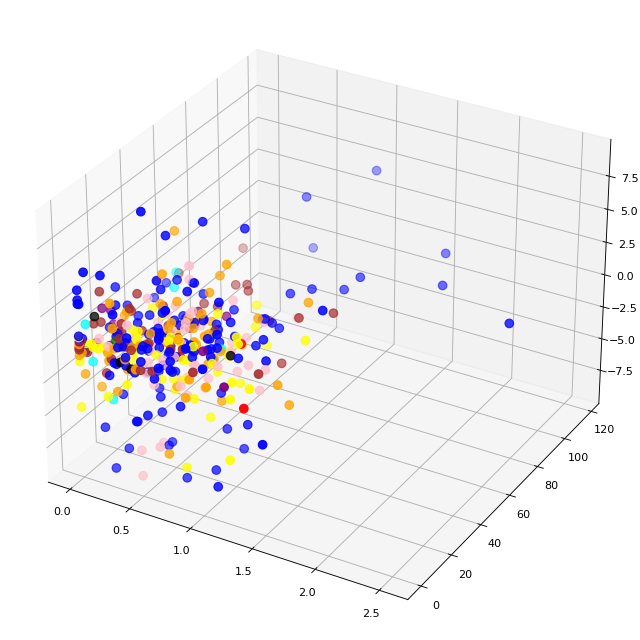

In [351]:
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
features['highway_enc'] = le.fit_transform(features['highway'])

X = np.array(features[["std_jerk","std_current","slope"]])
y = np.array(features['highway_enc'])
fig = plt.figure(figsize=[8,8])
ax = Axes3D(fig)
colores=['blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple','black']
asignar=[]
for row in y:
    asignar.append(colores[row])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)

### Determinando el número de clusters

<IPython.core.display.Javascript object>


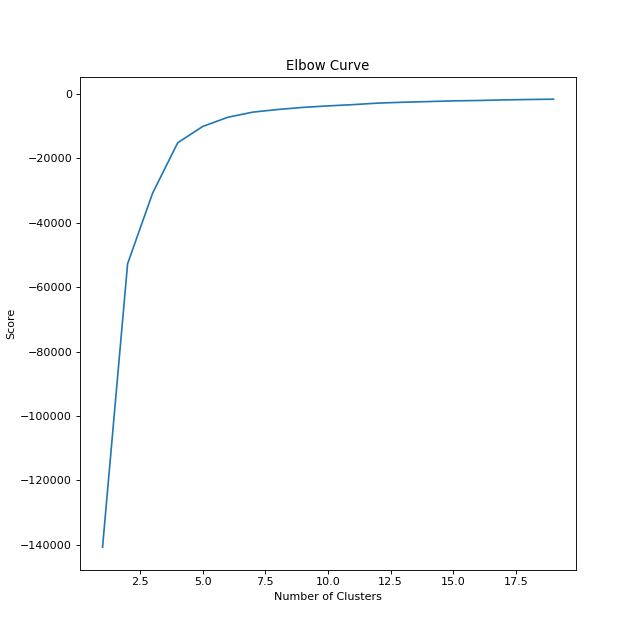

In [272]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
fig = plt.figure(figsize=[8,8])
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### Aplicando el modelo de cluster con n = 3

[[ 0.6451156  28.64669913  0.08496972]
 [ 0.44944156  7.9101783  -0.52537367]
 [ 0.91608011 73.88220088  0.41449049]]


<IPython.core.display.Javascript object>


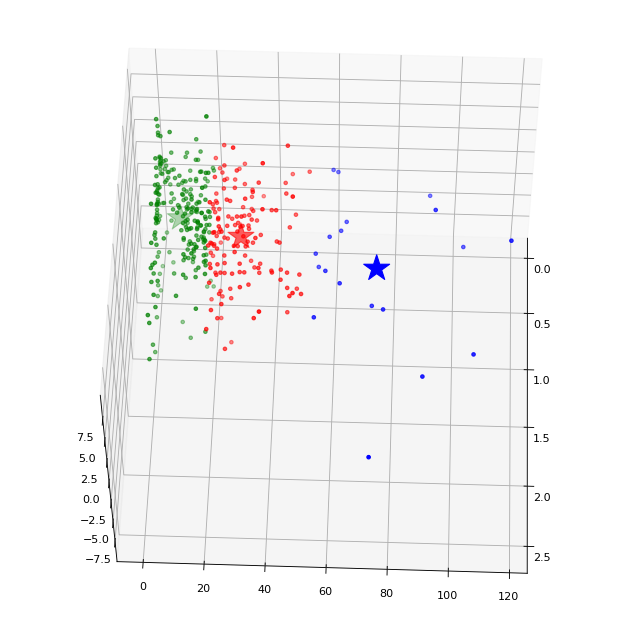

In [352]:
kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure(figsize=[8,8])
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=10)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=600)

### Aplicando el modelo de cluster con n = 2

[[ 0.47310918 13.28615696 -0.38575578]
 [ 0.82313925 53.34527991  0.72742332]]


<IPython.core.display.Javascript object>


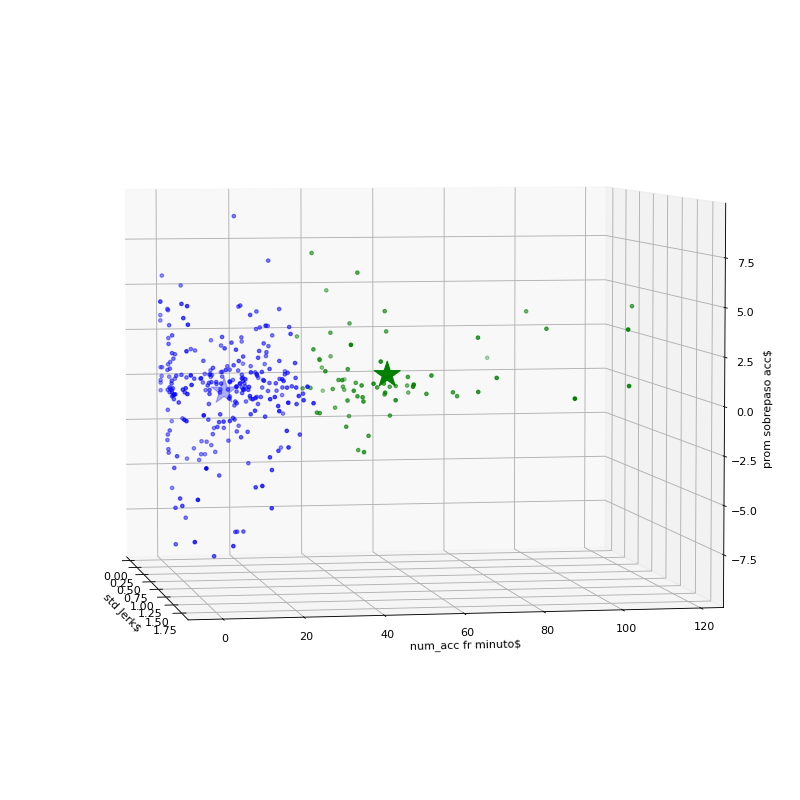

Text(0.5, 0, 'prom sobrepaso acc$')

In [274]:
kmeans = KMeans(n_clusters=2).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['blue','green']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure(figsize=[10,10])
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=10)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=600)
ax.set_xlabel('std Jerk$')
ax.set_ylabel('num_acc fr minuto$')
ax.set_zlabel('prom sobrepaso acc$')

### Utilizando el algoritmo de OPTICS

In [281]:
from sklearn.cluster import OPTICS
clustering = OPTICS(min_samples=30, max_eps=30).fit(X)
labels = clustering.labels_
print(labels)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1 -1 -1  1 -1
  1  0  1 -1 -1  1  1 -1  1  0 -1 -1  1 -1 -1  1  0  0  0  0  0  1 -1  1
  1  1  1 -1  1  1  1  1  1  1 -1  0 -1  1  1  1  1  1  1 -1  1  1  1 -1
  0  1  1  1  1  1 -1  1  1  1  1  1  0  1 -1  1  1  1  0  1  1  1 -1 -1
 -1  1  1 -1 -1 -1 -1 -1 -1  1  1  1 -1  1  1  1  1  1  1 -1 -1  1 -1 -1
 -1 -1  1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1
  1  1  1  1 -1 -1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1 -1 -1  1 -1 -1
  1 -1 -1  1 -1 -1  1 -1  0 -1 -1 -1  0  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  0  1  1  1
  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

<IPython.core.display.Javascript object>


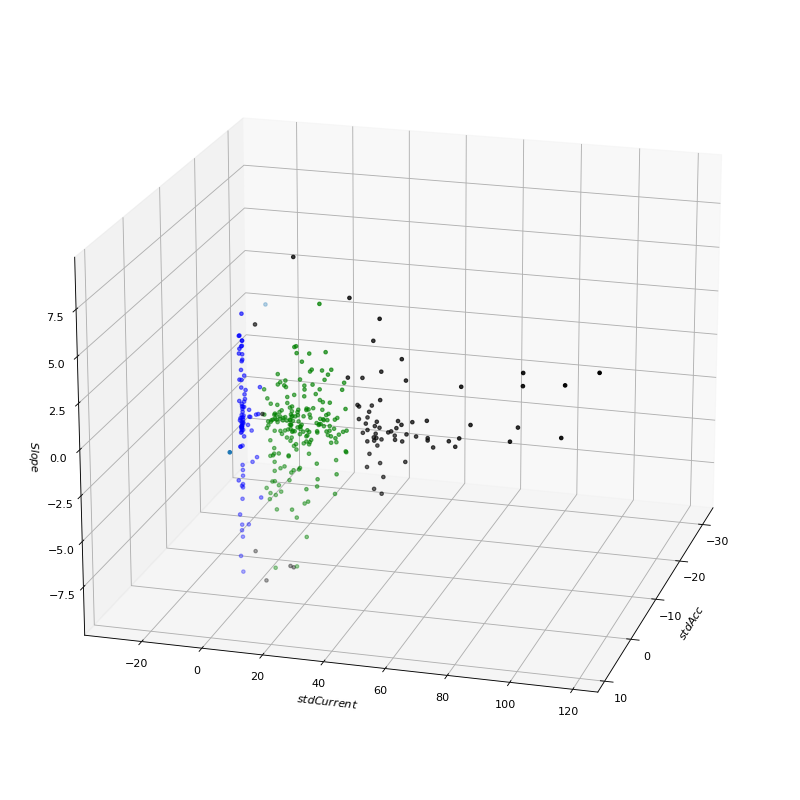

Text(0.5, 0, '$Slope$')

In [282]:

# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['blue','green']  #, 'yellow'] #'cyan', 'red', 'brown']
asignar=[]
for row in labels:
    if row == -1:
        asignar.append('black')
    else:
        asignar.append(colores[row])

fig = plt.figure(figsize=[10,10])
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=10)
# ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=600)
ax.set_xlabel('$std Acc$')
ax.set_ylabel('$std Current$')
ax.set_zlabel('$Slope$')

### Aplicando PCA

In [360]:
from sklearn.decomposition import PCA

X = np.array(features[['num_acc_minuto', 'num_acc_fr_minuto', 'prom_sobrepaso_acc', 'prom_sobrepaso_fren', 'prom_abs_acc',
                           'std_acc', 'num_jerk_acc_minuto', 'num_jerk_freno_minuto', 'prom_sobrepaso_jerk_acc',
                           'prom_sobrepaso_jerk_freno', 'prom_abs_jerk', 'std_jerk', 'std_potencia', 'prom_abs_potencia',
                           'consumption', 'kms', 'consumption_per_km', 'num_current_minuto', 'num_current_fr_minuto',
                           'prom_sobrepaso_current', 'prom_sobrepaso_current_fr', 'prom_abs_current', 'std_current',
                           'std_current_std_jerk', 'slope', 'max_current', 'max_jerk', 'max_acc', 'max_power',
                           'max_speed', 'mean_speed', 'std_speed']])


pca = PCA()
pca.fit(X)
print((pca.explained_variance_ratio_)[0:3])
print((pca.explained_variance_ratio_)[0:3].sum())

[0.69891831 0.13952757 0.06589826]
0.9043441390336945


We know now that the first two principal components accounts for 92.5% of the variation

<IPython.core.display.Javascript object>


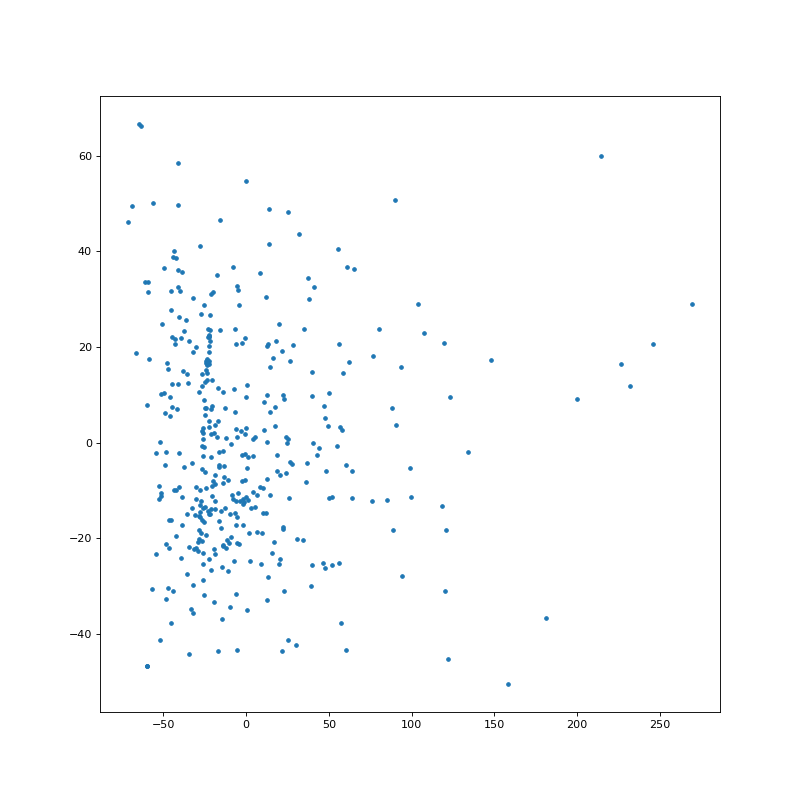

In [359]:
pca = PCA(n_components=2)
pca.fit(X)
X_transformed = pca.transform(X)
fig = plt.figure(figsize=[10,10])
plt.scatter(x=X_transformed[:,0], y=X_transformed[:,1],s=10)


### Selecting the number of clusters with silhouette analysis

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),
             fontsize=14, fontweight='bold')

plt.show()

# Read a file with linear model

In [15]:
new_results = sm.load('./lm_aggresivity.pickle')